In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot
pyplot.ion()
pyplot.style.use('dark_background')

import torch as th
from torch import autograd as tha
from torch.utils import data


From expert_rollouts/Hopper-v1/n20_1.pkl
Loaded observations: (20000, 11)
Loaded actions: (20000, 3)


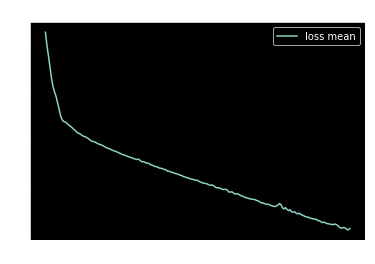

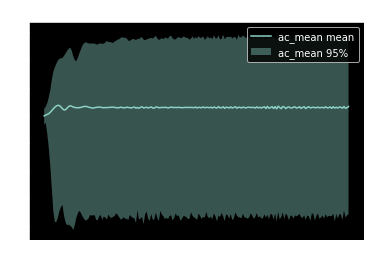

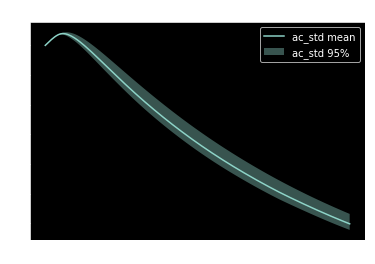

In [6]:
# Section 2: Warmup Behavior Cloning.

import os
import pickle

from rl.algs import plotter
from rl.algs.pg import Environment

dtype = th.cuda.FloatTensor

os.chdir('/home/z/code/blaze_root/src/rl/berkeleyrlcourse/hw1')

class Model(th.nn.Module):
  def __init__(self, obs_dim, action_dim, hidden_dim):
    super().__init__()
    self.base_nn = th.nn.Sequential(
      th.nn.Linear(obs_dim, hidden_dim),
      th.nn.ReLU(),
      th.nn.Linear(hidden_dim, hidden_dim),
      th.nn.ReLU(),
      th.nn.Linear(hidden_dim, hidden_dim),
      th.nn.ReLU(),
    )
    self.means = th.nn.Linear(hidden_dim, action_dim)
    self.logstds = th.nn.Parameter(th.zeros((1, action_dim)).type(dtype))

  def forward(self, x):
    x = self.base_nn(x)
    return self.means(x), self.logstds

class ImitationPolicy(object):
  """Continuous action policy, trained on imitation."""
  def __init__(self, expert_dataset, lr=0.001):
    self.obs_dim = expert_dataset.obs.shape[-1]
    self.action_dim = expert_dataset.acs.shape[-1]
    self.model = self.create_model()
    self.optimizer = th.optim.Adam(self.model.parameters(), lr)
 
  def create_model(self):
    hidden_dim = 64
    model = Model(self.obs_dim, self.action_dim, hidden_dim)
    model.cuda()
    return model
  
  def _get_action_distribution(self, obs_var):
    means, logstds = self.model(obs_var)
    stds = th.exp(logstds)
    dist = th.distributions.Normal(means, stds)
    return dist

  def step(self, obs_batch, acs_batch):
    metrics = {}
    obs_var = tha.Variable(obs_batch.type(dtype))
    acs_var = tha.Variable(acs_batch.type(dtype))
    dist = self._get_action_distribution(obs_var)
    log_probs = dist.log_prob(acs_var)
    loss = -log_probs.mean()
    
    metrics['loss'] = loss.data.cpu().numpy()[0]
    metrics['ac_mean'] = dist.mean.data.cpu().numpy()
    metrics['ac_std'] = dist.std.data.cpu().numpy()
    
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
 
    return metrics

class ExpertDataset(object):
  def __init__(self, pkl_file, batch_size):
    with open(pkl_file, 'rb') as fd:
      rollouts = pickle.load(fd)
    self.obs = rollouts['observations']
    self.acs = rollouts['actions']
    
    print(f'From {pkl_file}')
    print(f'Loaded observations: {self.obs.shape}')
    print(f'Loaded actions: {self.acs.shape}')
    
    obs_tensor = th.from_numpy(self.obs).cuda()
    acs_tensor = th.from_numpy(self.acs).cuda()
    
    dataset = data.TensorDataset(obs_tensor, acs_tensor)
    self.data_loader = data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False)
    
  def __iter__(self):
    return iter(self.data_loader)


NUM_EPOCHS = 20
MINI_BATCH_SIZE = 2000
plt = plotter.Plotter()

pkl_file = 'expert_rollouts/Hopper-v1/n20_1.pkl'
#pkl_file = 'expert_rollouts/Humanoid-v1/n1_1.pkl'
expert_ds = ExpertDataset(pkl_file, batch_size=MINI_BATCH_SIZE)
policy = ImitationPolicy(expert_ds, lr=0.005)

mini_i = 0
for i in range(NUM_EPOCHS):
  for obs_batch, acs_batch in expert_ds:
    metrics = policy.step(obs_batch, acs_batch)
    mini_i += 1
    for name, values in metrics.items():
      plt.add_data(name, mini_i, values)

plt.line_plot()
plt.render()


In [5]:
# Show an episode of the final policy
try:
  _ = env.sample_rollouts(policy.get_action, 1, render=True)
finally:
  env.env.render(close=True)


NameError: name 'env' is not defined

In [9]:
# Scratchpad
import torch as th

mu = th.Tensor([0, 0.5, 1.0])
std = th.Tensor([1.0, 1.0, 1.0])

d = th.distributions.Normal(mu, std)
print(d)
a = th.Tensor([0, 0, 1.0])
th.exp(d.log_prob(a))

l = th.distributions.Normal(-0.2649, 1.1248).log_prob(-0.8086)
th.exp(th.Tensor([l]))



[4, 3, 2, 1]